In [1]:
import pathlib
import pandas as pd
import yaml
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
PATH_TO_RUNS = "multirun/2021-11-26/02-08-07/"
path = pathlib.Path(PATH_TO_RUNS).resolve()

In [3]:
df = []
for i, _path in enumerate(sorted(path.glob('**/*.csv'))):
    hydra_path = _path.parent / ".hydra" / "config.yaml"
    with open(hydra_path, "r") as f:
        hydra_dict = yaml.load(f, yaml.SafeLoader)
    df_view = pd.read_csv(_path)
    df_view["n_segments"] = hydra_dict["dataset"]["n_segments"]
    df.append(df_view)

df = pd.concat(df)

In [4]:
df_file = df[["file", "file_approx_time", "n_segments"]].drop_duplicates().reset_index(drop=True)

In [5]:
top_segments = df_file[df_file.n_segments.max() == df_file.n_segments].sort_values(by="file_approx_time", ascending=False).file.drop_duplicates()[:5]

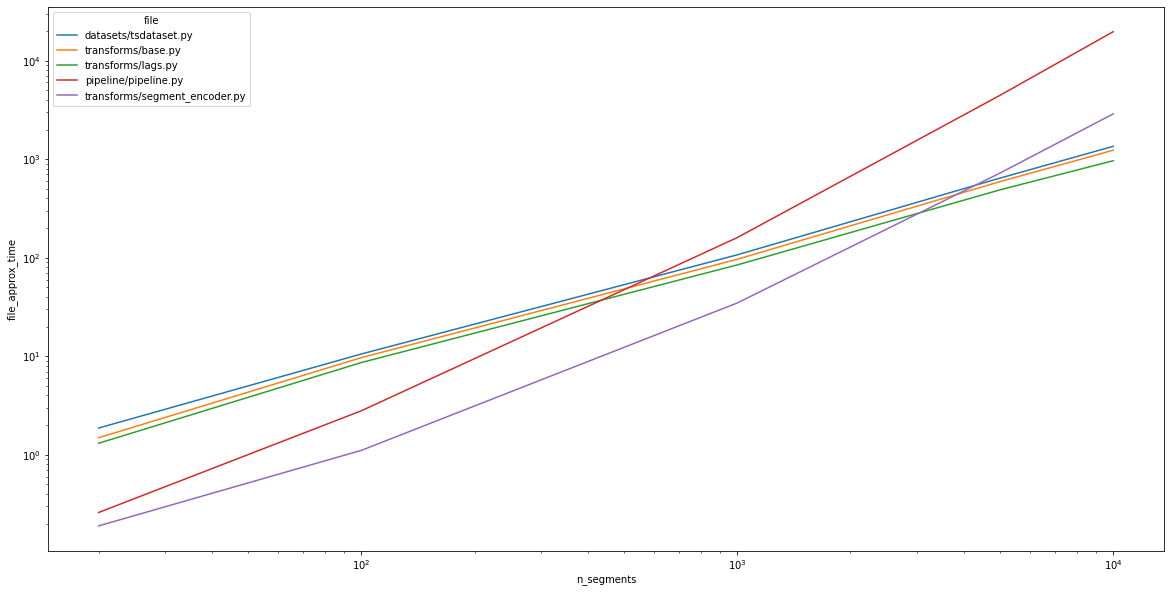

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(
    data=df_file[df_file.file.isin(top_segments)],
    x="n_segments", y="file_approx_time", hue="file", ax=ax
)
ax.set_yscale('log')
ax.set_xscale('log')

In [7]:
df_file_pivot = df_file[df_file.file.isin(top_segments)].pivot(columns="n_segments", index="file")

In [8]:
df_function = df.groupby(["function", "n_segments"]).approx_time.sum().reset_index()
top_functions = df_function[df_function.n_segments.max() == df_function.n_segments].sort_values(by="approx_time", ascending=False).function.drop_duplicates()[:10]

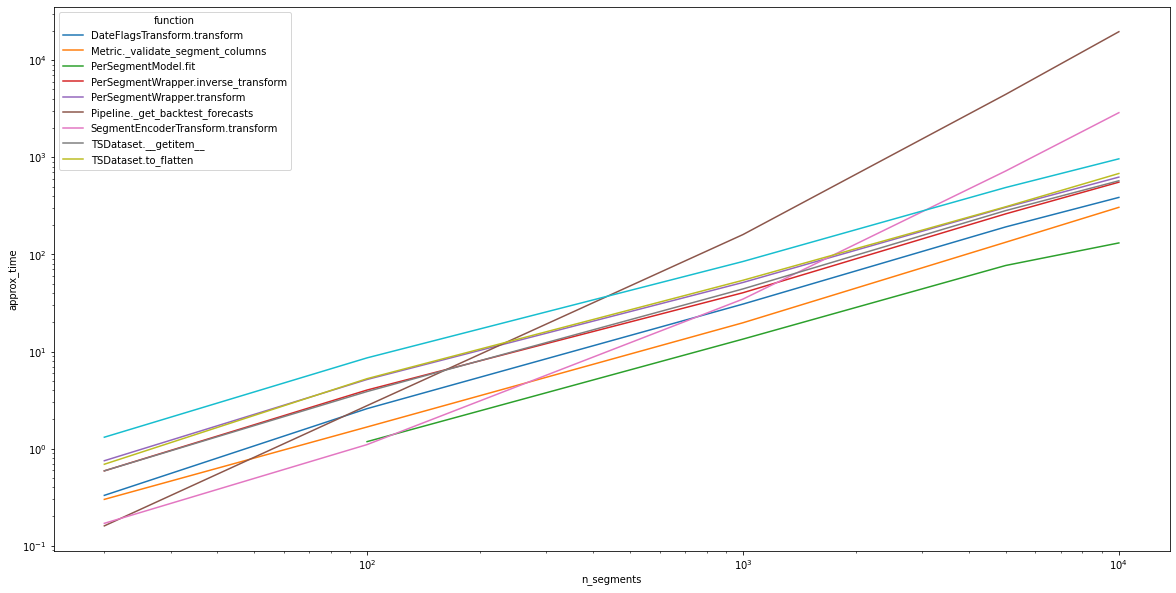

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(
    data=df_function[df_function.function.isin(top_functions)],
    x="n_segments", y="approx_time", hue="function", ax=ax
)
ax.set_yscale('log')
ax.set_xscale('log')

In [10]:
df_function_pivot = df_function[df_function.function.isin(top_functions)].pivot(columns="n_segments", index="function")

In [11]:
import statsmodels.api as sm
import numpy as np
ols_params_per_function = dict()
for index_name, series in df_function_pivot.iterrows():
    series = series.dropna()
    Y = np.log(series.values)
    X = np.log([[i[1]] for i in series.index])
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    ols_params_per_function[index_name] = results.params[1]


In [12]:
pd.Series(ols_params_per_function).sort_values(ascending=False)

Pipeline._get_backtest_forecasts       1.876624
SegmentEncoderTransform.transform      1.574865
DateFlagsTransform.transform           1.129798
Metric._validate_segment_columns       1.112468
TSDataset.__getitem__                  1.104395
TSDataset.to_flatten                   1.091964
PerSegmentWrapper.inverse_transform    1.091380
PerSegmentWrapper.transform            1.072193
_OneSegmentLagFeature.transform        1.055129
PerSegmentModel.fit                    1.037473
dtype: float64

In [13]:
df_function_pivot

approx_time                         \
n_segments                                20    100     1000     5000    
function                                                                 
DateFlagsTransform.transform               0.33  2.58   30.78   191.91   
Metric._validate_segment_columns           0.30  1.67   19.77   133.43   
PerSegmentModel.fit                         NaN  1.18   13.42    76.90   
PerSegmentWrapper.inverse_transform        0.59  4.01   40.29   261.59   
PerSegmentWrapper.transform                0.75  5.15   51.39   305.12   
Pipeline._get_backtest_forecasts           0.16  2.77  160.05  4448.55   
SegmentEncoderTransform.transform          0.17  1.10   34.66   722.81   
TSDataset.__getitem__                      0.59  3.87   44.11   282.59   
TSDataset.to_flatten                       0.69  5.25   54.14   309.35   
_OneSegmentLagFeature.transform            1.31  8.60   84.52   488.55   

                                               
n_segments                              10000  
function                                       
DateFlagsTransform.transform           386.25  
Metric._validate_segment_columns       305.34  
PerSegmentModel.fit                    131.24  
PerSegmentWrapper.inverse_transform    554.39  
PerSegmentWrapper.transform            625.16  
Pipeline._get_backtest_forecasts     19653.69  
SegmentEncoderTransform.transform     2881.01  
TSDataset.__getitem__                  572.76  
TSDataset.to_flatten                   681.29  
_OneSegmentLagFeature.transform        964.38